# Import thư viện

In [1]:
# Thư viện cơ bản
import numpy as np
import pandas as pd

# Bỏ qua các cảnh báo
import warnings
warnings.filterwarnings('ignore')

# Thư viện vẽ biểu đồ
import matplotlib.pyplot as plt
import seaborn as sns   

# Thư viện tiền xử lý dữ liệu, tối ưu hóa mô hình
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer

# Thư viện xây dựng mô hình
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Thư viện đánh giá mô hình
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc, confusion_matrix, classification_report, precision_score

df = pd.read_csv('water_potability.csv')
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


Potability
0    1998
1    1278
Name: count, dtype: int64

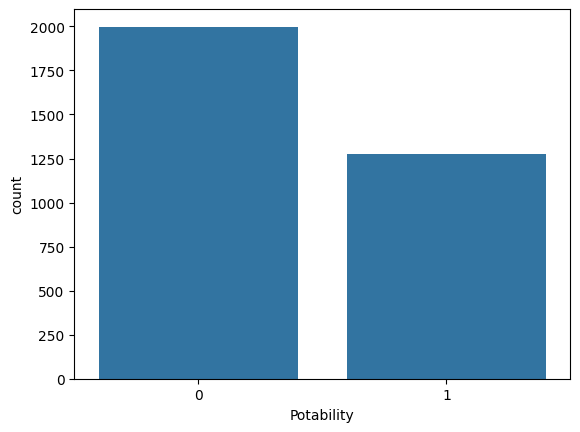

In [3]:
# 0 - Không uống được
# 1 - Uống được
sns.countplot(x = df['Potability'])
df['Potability'].value_counts()

In [4]:
df.shape

# 3276 dòng, 10 cột

(3276, 10)

# Tiền xử lý dữ liệu

## Các bước đã làm ở tiền xử lý dữ liệu:
1. Điền null
- Lí do cần điền null:
+ Mô hình sẽ báo lỗi hoặc cho kết quả sai nếu có ô bị null, vì nó không thể học được gì từ ô đó.
+ Nếu không điền thì chỉ còn cách xóa cả hàng có chứa ô null, dẫn đến mất dữ liệu.
+ Một số phương pháp chuẩn hóa như: MinMaxScaler, StandardScaler, thì null sẽ làm hỏng quá trình scale.
- Phương pháp điền null:
+ Do các cột đều có phân phối khá chuẩn (Normal distribution), nên chọn phương pháp điền bằng trung vị (median).
+ Các cột có null và % null: pH (~15%), Sulfate (~24%) và Trihalomethanes (~5%).
+ Cột Trihalomethanes thiếu ít, nên điền thẳng median vào các cột null.
+ Cột pH và Sulfate thiếu tương đối, dù vẫn điền bằng median nhưng gộp theo nhãn (median riêng của nhãn 0 và 1) rồi điền.
2. Xử lý ngoại lai
- Lí do cần xử lý ngoại lai:
+ Một vài giá trị cao hoặc quá cao so với bình thường có thể kéo lệch trung bình, phương sai, làm sai các phép tính thống kê.
+ Nếu dùng mô hình nhạy cảm với ngoại lai (ví dụ: KNN - tính theo khoảng cách) thì ngoại lai có thể khiến mô hình học sai bản chất.
+ Một số phương pháp chuẩn hóa như: MinMaxScaler thì ngoại lai sẽ làm hỏng quá trình scale.
- Phương pháp xử lí ngoại lai:
+ Ở đây sử dụng phương pháp 1.5 * IQR (Interquantile range: Khoảng trong phân vị từ 25% - 75%).
+ Gán ngưỡng trên và ngưỡng dưới cách Q1 và Q3 1 khoảng bằng 1.5 lần IQR.
+ Nếu ngoại lai lớn hơn ngưỡng trên sẽ được ghi đè thành giá trị ở ngưỡng trên, tương tự với ngưỡng dưới.
+ Cách này đảm bảo dữ liệu không bị mất như việc xóa hẳn outlier.

In [5]:
# Check duplicate
df.duplicated().sum()

np.int64(0)

In [6]:
print(df.isnull().sum()[df.isnull().sum() > 0])
(df.isnull().sum()[df.isnull().sum() > 0] / len(df) * 100).round(2)

ph                 491
Sulfate            781
Trihalomethanes    162
dtype: int64


ph                 14.99
Sulfate            23.84
Trihalomethanes     4.95
dtype: float64

In [7]:
df[df['Potability'] == 0].describe().T

,count,mean,std,min,25%,50%,75%,max
ph,1684.0,7.085378,1.683499,0.000000,6.037723,7.035456,8.155510,14.000000
Hardness,1998.0,196.733292,31.057540,98.452931,177.823265,197.123423,216.120687,304.235912
Solids,1998.0,21777.490788,8543.068788,320.942611,15663.057382,20809.618280,27006.249009,61227.196008
Chloramines,1998.0,7.092175,1.501045,1.683993,6.155640,7.090334,8.066462,12.653362
Sulfate,1510.0,334.564290,36.745549,203.444521,311.264006,333.389426,356.853897,460.107069
Conductivity,1998.0,426.730454,80.047317,181.483754,368.498530,422.229331,480.677198,753.342620
Organic_carbon,1998.0,14.364335,3.334554,4.371899,12.101057,14.293508,16.649485,28.300000
Trihalomethanes,1891.0,66.303555,16.079320,0.738000,55.706530,66.542198,77.277704,120.030077
Turbidity,1998.0,3.965800,0.780282,1.450000,3.444062,3.948076,4.496106,6.739000
Potability,1998.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [8]:
df[df['Potability'] == 1].describe().T

,count,mean,std,min,25%,50%,75%,max
ph,1101.0,7.073783,1.448048,0.227499,6.179312,7.036752,7.933068,13.175402
Hardness,1278.0,195.800744,35.547041,47.432000,174.330531,196.632907,218.003420,323.124000
Solids,1278.0,22383.991018,9101.010208,728.750830,15668.985035,21199.386614,27973.236446,56488.672413
Chloramines,1278.0,7.169338,1.702988,0.352000,6.094134,7.215163,8.199261,13.127000
Sulfate,985.0,332.566990,47.692818,129.000000,300.763772,331.838167,365.941346,481.030642
Conductivity,1278.0,425.383800,82.048446,201.619737,360.939023,420.712729,484.155911,695.369528
Organic_carbon,1278.0,14.160893,3.263907,2.200000,12.033897,14.162809,16.356245,23.604298
Trihalomethanes,1223.0,66.539684,16.327419,8.175876,56.014249,66.678214,77.380975,124.000000
Turbidity,1278.0,3.968328,0.780842,1.492207,3.430909,3.958576,4.509569,6.494249
Potability,1278.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: xlabel='Trihalomethanes', ylabel='Count'>

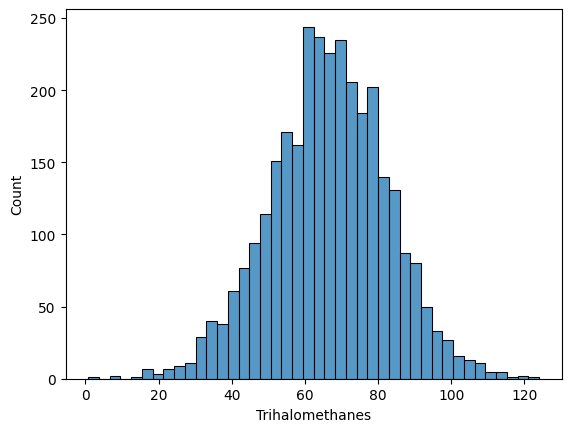

In [9]:
sns.histplot(df['Trihalomethanes'])

<Axes: xlabel='ph', ylabel='Count'>

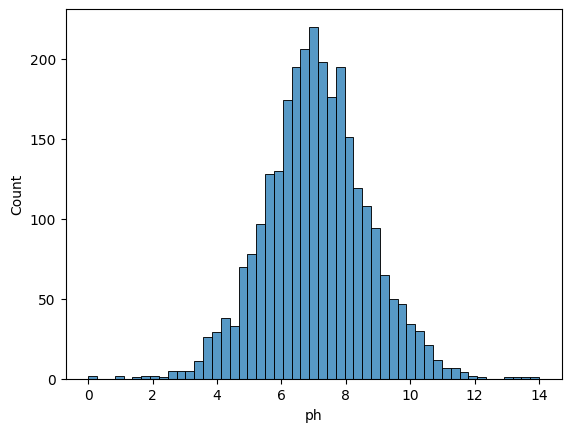

In [10]:
sns.histplot(df['ph'])

<Axes: xlabel='Sulfate', ylabel='Count'>

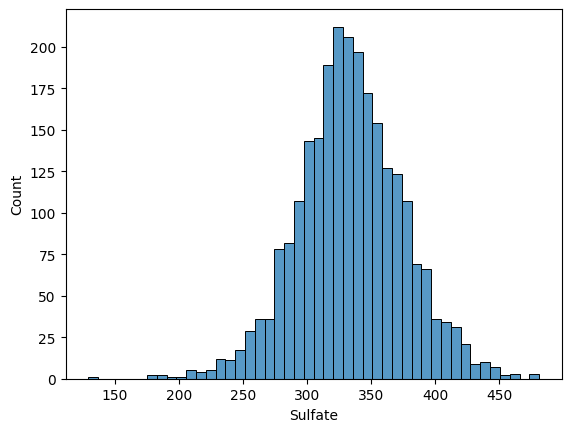

In [11]:
sns.histplot(df['Sulfate'])

- Phân phối gần như chuẩn, chỉ có Sulfate hơi lệch trái

In [12]:
# Xem trung bình, trung vị của 3 cột có giá trị null theo nhãn 0
print(df[df['Potability']==0][['ph','Sulfate','Trihalomethanes']].mean()) 
print('\n')
print(df[df['Potability']==0][['ph','Sulfate','Trihalomethanes']].median())

ph                   7.085378
Sulfate            334.564290
Trihalomethanes     66.303555
dtype: float64


ph                   7.035456
Sulfate            333.389426
Trihalomethanes     66.542198
dtype: float64


In [13]:
# Xem trung bình, trung vị của 3 cột có giá trị null theo nhãn 1
df[df['Potability']==1][['ph','Sulfate','Trihalomethanes']].mean()
print('\n')
df[df['Potability']==1][['ph','Sulfate','Trihalomethanes']].median()

ph                   7.036752
Sulfate            331.838167
Trihalomethanes     66.678214
dtype: float64

# Chia train, test 

Chia tập huấn luyện (train) và tập thử nghiệm (test)
- Để mô hình học ở tập train rồi đưa ra phán đoán ở tập test, so sánh sự đúng sai trên so với kết quả của tập test.
- Tập train sẽ chiếm 70% dữ liệu, tập test chiếm 30%.

In [14]:
X = df.drop('Potability', axis=1)
y = df['Potability']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

## KNN Imputer

In [16]:
cols_to_fill = ['Trihalomethanes', 'ph', 'Sulfate']

In [17]:
X_train_filled = X_train.copy()
X_test_filled = X_test.copy()

for label in [0, 1]:
    # Chỉ số của từng nhóm
    train_idx = y_train[y_train == label].index
    test_idx = y_test[y_test == label].index

    # Fit trên train nhóm đó
    imputer = KNNImputer(n_neighbors=5)
    imputer.fit(X_train.loc[train_idx, cols_to_fill])

    # Transform train
    imputed_train = imputer.transform(X_train.loc[train_idx, cols_to_fill])
    X_train_filled.loc[train_idx, cols_to_fill] = pd.DataFrame(
        imputed_train, columns=cols_to_fill, index=train_idx
    )

    # Transform test
    imputed_test = imputer.transform(X_test.loc[test_idx, cols_to_fill])
    X_test_filled.loc[test_idx, cols_to_fill] = pd.DataFrame(
        imputed_test, columns=cols_to_fill, index=test_idx
    )

In [18]:
print(X_train_filled.isnull().sum()[X_train.isnull().sum() > 0])
print(X_test_filled.isnull().sum()[X_test_filled.isnull().sum() > 0])

ph                 0
Sulfate            0
Trihalomethanes    0
dtype: int64
Series([], dtype: int64)


# Chạy mô hình

In [19]:
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train_filled, y_train)

DecisionTreeClassifier(random_state=42)

In [20]:
y_pred = decision_tree.predict(X_test_filled)

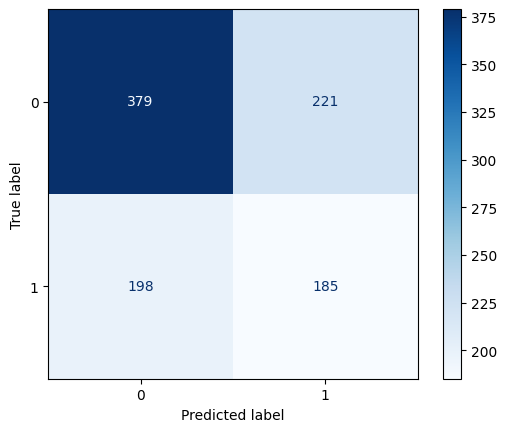

In [21]:
cm = confusion_matrix(y_test, y_pred)
display_cm = ConfusionMatrixDisplay(confusion_matrix=cm)
display_cm.plot(cmap='Blues')

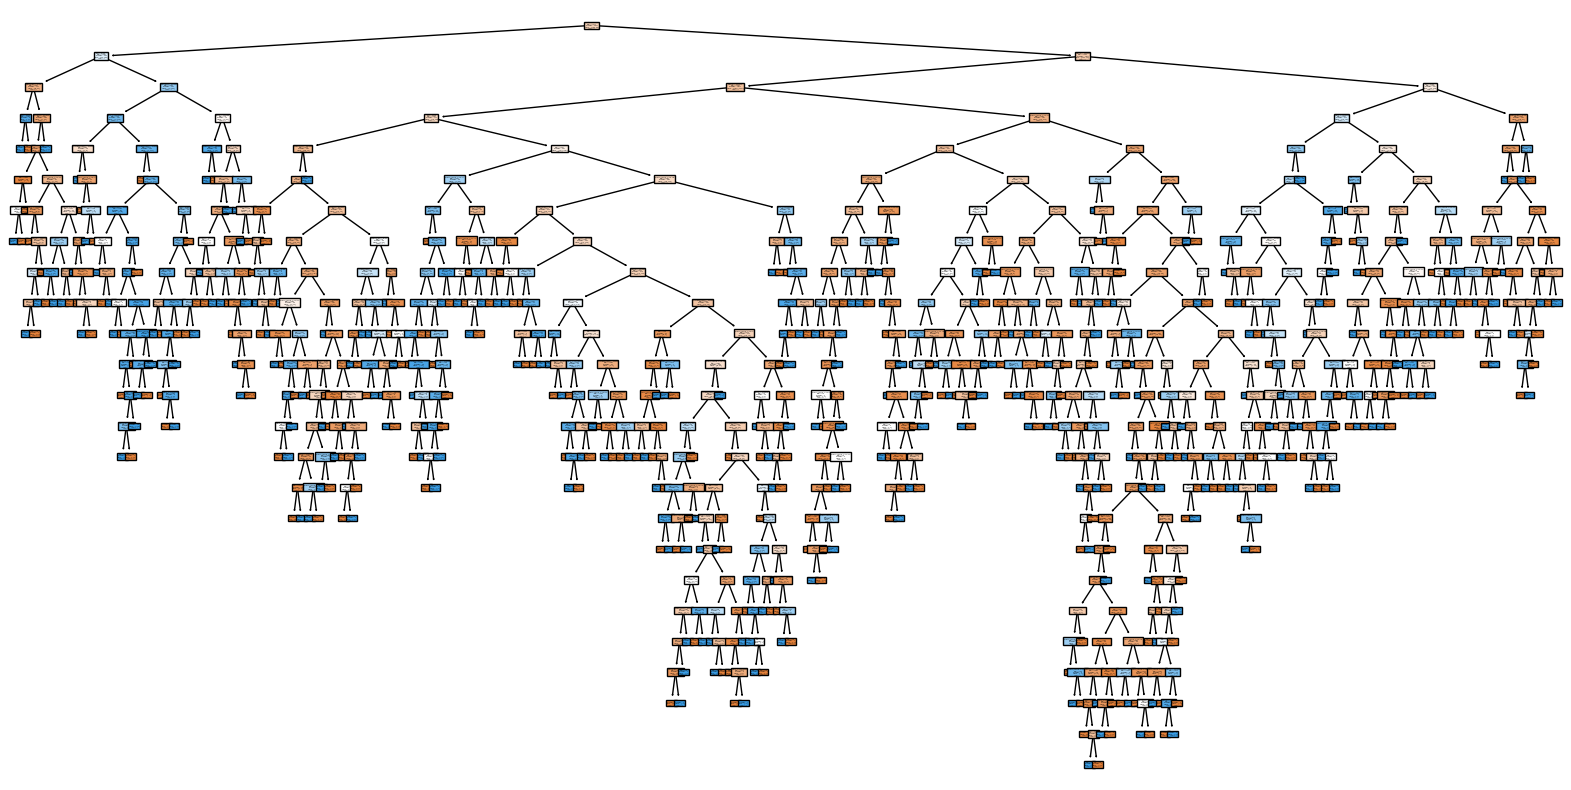

In [22]:
plt.figure(figsize=(20,10))
plot_tree(decision_tree, filled=True, feature_names=df.columns[:-1], class_names=['0', '1'])
plt.show()

# Cây chưa tối ưu

# Tối ưu mô hình

In [23]:
param_grid = {
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 8],
    'min_samples_leaf': [1, 4],
    'criterion': ['entropy', 'gini'],
    'class_weight': [None, 'balanced']
}

In [24]:
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=param_grid, cv=5, scoring='precision', n_jobs=-1, verbose=1)
grid_search.fit(X_train_filled, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['entropy', 'gini'],
                         'max_depth': [4, 6, 8], 'min_samples_leaf': [1, 4],
                         'min_samples_split': [2, 8]},
             scoring='precision', verbose=1)

In [25]:
grid_search.best_params_

{'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 4,
 'min_samples_leaf': 4,
 'min_samples_split': 2}

In [26]:
best_decision_tree = grid_search.best_estimator_

In [27]:
y_proba = grid_search.predict_proba(X_test_filled)[:, 1]

In [28]:
# Tạo 1 chuỗi threshold (ngưỡng) từ 0.0 đến 1.0, bước nhảy 0.01
threshold = np.arange(0.0, 1.01, 0.01)

# 1 mảng lưu kết quả từ confusion matrix (ma trận nhầm lẫn)
res = []

for t in threshold:
    y_pred = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    res.append((t, fp, fn, tp, tn))

In [29]:
df_thresh = pd.DataFrame(res, columns=['Threshold', 'FP', 'FN', 'TP', 'TN'])
df_thresh['Precision'] = df_thresh['TP'] / (df_thresh['TP'] + df_thresh['FP'])
df_thresh['Recall'] = df_thresh['TP'] / (df_thresh['TP'] + df_thresh['FN'])

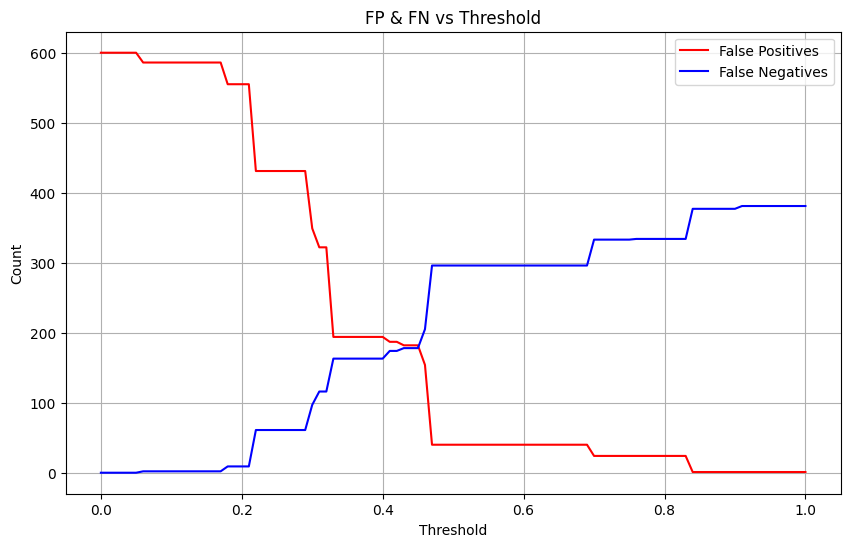

In [30]:
plt.figure(figsize=(10,6))
plt.plot(df_thresh["Threshold"], df_thresh["FP"], label="False Positives", color="red")
plt.plot(df_thresh["Threshold"], df_thresh["FN"], label="False Negatives", color="blue")
plt.xlabel("Threshold")
plt.ylabel("Count")
plt.title("FP & FN vs Threshold")
plt.legend()
plt.grid()
plt.show()

# Vẽ biểu đồ ngưỡng FP và FN theo Threshold

In [31]:
# In ra confusion matrix & classification report theo nhiều threshold khác nhau
for t in threshold:
    print(f"Threshold: {t:.2f}")
    y_pred = (y_proba >= t).astype(int)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

Threshold: 0.00
[[  0 600]
 [  0 383]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       600
           1       0.39      1.00      0.56       383

    accuracy                           0.39       983
   macro avg       0.19      0.50      0.28       983
weighted avg       0.15      0.39      0.22       983

Threshold: 0.01
[[  0 600]
 [  0 383]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       600
           1       0.39      1.00      0.56       383

    accuracy                           0.39       983
   macro avg       0.19      0.50      0.28       983
weighted avg       0.15      0.39      0.22       983

Threshold: 0.02
[[  0 600]
 [  0 383]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       600
           1       0.39      1.00      0.56       383

    accuracy                           0.39       983
   macro av

In [32]:
# Chọn ngưỡng 0.47
y_pred_best = (y_proba >= 0.47).astype(int)

In [33]:
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.65      0.93      0.77       600
           1       0.69      0.23      0.34       383

    accuracy                           0.66       983
   macro avg       0.67      0.58      0.56       983
weighted avg       0.67      0.66      0.60       983



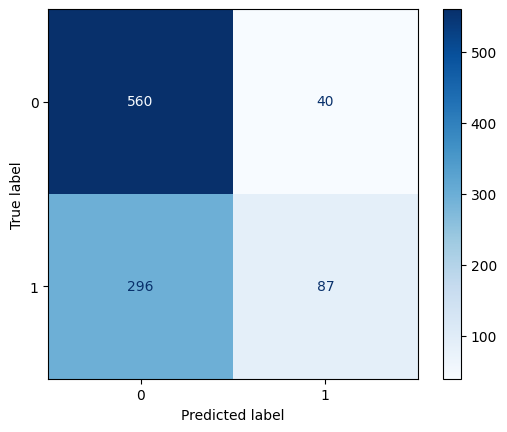

In [34]:
cm_best = confusion_matrix(y_test, y_pred_best)
display_cm_best = ConfusionMatrixDisplay(confusion_matrix=cm_best)
display_cm_best.plot(cmap='Blues')

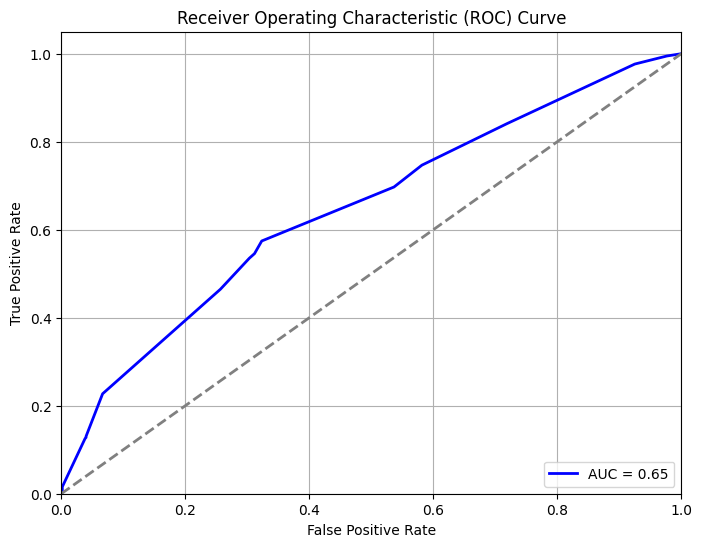

In [35]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # đường random guess
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

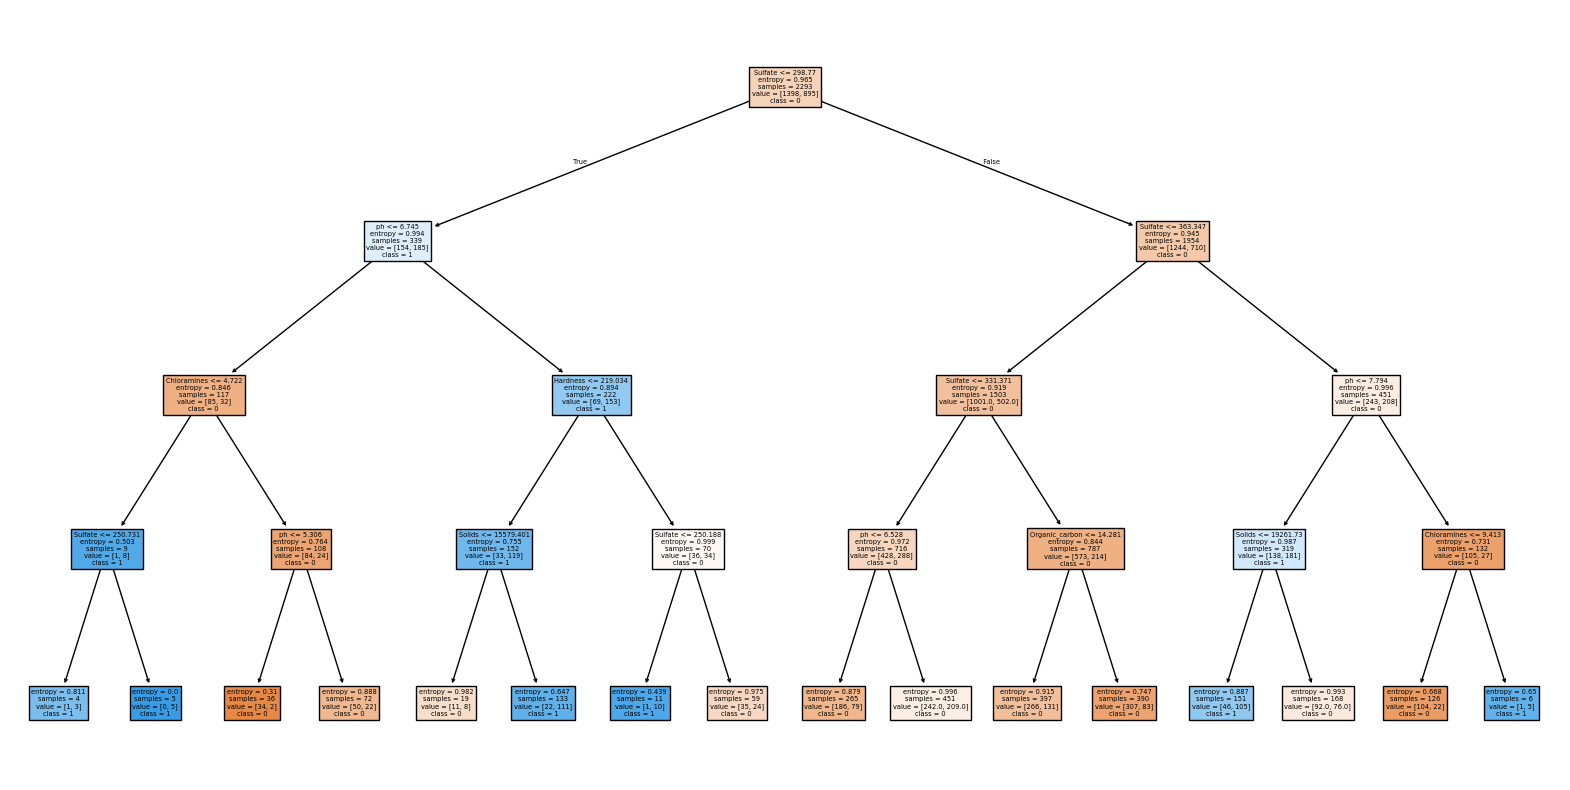

In [36]:
best_decision_tree = grid_search.best_estimator_

plt.figure(figsize=(20,10))
plot_tree(best_decision_tree, filled=True, feature_names=df.columns[:-1], class_names=['0', '1'])
plt.show()

# Cây đã tối ưu

In [42]:
# Kiểm tra độ quan trọng của thuộc tính đến mô hình
def check_importance(model, feature_names):
    importances = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    # Lọc các feature có độ quan trọng > 0
    importance_df = importance_df[importance_df['Importance'] > 0]
    return importance_df
    
    print(importance_df)

check_importance(best_decision_tree, df.columns[:-1])

,Feature,Importance
0,ph,0.407677
4,Sulfate,0.310787
2,Solids,0.099268
3,Chloramines,0.084242
1,Hardness,0.057058
6,Organic_carbon,0.040968


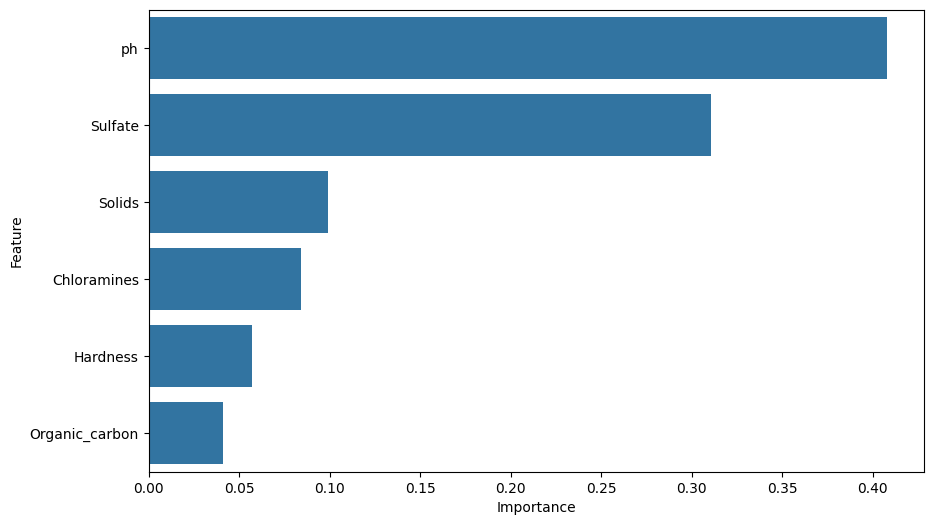

In [43]:
importance_df = check_importance(best_decision_tree, X_train_filled.columns)
plt.figure(figsize=(10,6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.show()